# Capstone Project 
--------
Topic: Home contents insurance

Student Name: Victor Acosta

Student ID: 534

Training data: https://www.kaggle.com/datasets/xavierdataset/stable-home-insurance-data-driven-growth

<span style="color: lightgreen;"><b>This document is structured and divided into steps, following all the lifecycle stages of a ML project learned in Module 2</b></span>

### Step 1.  Define the purpose of the ML project

__Business case__: Pattern-matching risk analysis on new contents insurance policies.<br />
__Input__: customer details, property details and geolocation details<br />
__Output__: Risk or no risk<br />
__Target Audience__: Just myself as this is a unreal situation. In a real situation the underwritter will have access to this tool when giving quotes to new potential customers


### Step 2. Obtain the data


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, datetime  
from dateutil.parser import parse
import math 
import warnings
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.inspection import permutation_importance

train_datafile = "data/home_insurance.csv"

no_risk_balance = 0.5

# Columns mapped one to one from the datasource (just the columns relevant to this business case)
columns = [ "P1_EMP_STATUS",     #Customer profesional status
            "BUS_USE",           #Policy for Business 
            "RISK_RATED_AREA_C", #Geographical classificaton of Risk personal objects            
            "CONTENTS_COVER",    #Coverage for personal items indicator
            "SPEC_ITEM_PREM",    #Premium personal items   
            "P1_MAR_STATUS",     #Marital status
            "P1_SEX",            #Gender 
            "P1_DOB",            #Date of birth 
            "P1_POLICY_REFUSED", #Policy refused
            "APPR_ALARM",        #Appropriate alarm
            "APPR_LOCKS",        #Appropiate locks
            "BEDROOMS", 
            "WALL_CONSTRUCTION", 
            "NEIGH_WATCH",
            "OCC_STATUS",        #Occupancy status
            "OWNERSHIP_TYPE",    #Type of ownership
            "PAYING_GUESTS",     #Tenants in the property
            "PROP_TYPE", 
            "SAFE_INSTALLED",
            "YEARBUILT", 
            "LEGAL_ADDON_PRE_REN",    #Legal fees included
            "HOME_EM_ADDON_PRE_REN",  #Emergencies option included
            "KEYCARE_ADDON_PRE_REN",  #Replacement of keys included
            "FLOODING",               #Flooding risk 
            "SUBSIDENCE",             #Subsidence risk 
            "LISTED",                 #Listed as protected property
            "SUM_INSURED_CONTENTS",   #Premium
            "CLAIM3YEARS"]

# Better naming for the above columns
features = ["EMPLOYMENT",     #R = Retired,E = Employed,N = Not Available,H = House person,S = Student ,U = Unemployed.
            "BUS_USE",         
            "RISK_RATED_AREA_C", 
            "CONTENTS_COVER",   
            "SPEC_ITEM_PREM",   
            "MAR_STATUS",     #M: Married, P: Partnered, O: Other, W: Widowed,S: Single,D: Divorced,A: Annulled,C: Common-law,B: Betrothed, N: Never Married
            "SEX",            
            "DOB",            
            "POLICY_REFUSED",
            "ALARM",       
            "LOCKS",       
            "BEDROOMS", 
            "WALL_CONSTRUCTION", 
            "NEIGH_WATCH",
            "OCCUPANCY",  # 'PH': 'Policy Holder's Residence', 'LP': 'Leaseholder Property', 'HH': 'Holiday Home', 'UN': 'Unoccupied', 'WD': 'Weekday Home', 'WE': 'Weekend Home', 'OT': 'Other'
            "OWNERSHIP_TYPE",
            "PAYING_GUESTS", 
            "PROP_TYPE", 
            "SAFE_INSTALLED",
            "YEARBUILT", 
            "LEGALFEES_COVER", 
            "EMERGENCIES_COVER", 
            "KEYREPLACE_COVER", 
            "FLOODING_RISK",    
            "SUBSIDENCE_RISK",  
            "LISTED",   # 1.0 to 5.0        
            "SUM_INSURED", 
            "CLAIM3YEARS"] 


dataset = pd.read_csv(train_datafile)

dataset.columns = dataset.columns.str.strip()

dataset = dataset[columns]

rename_dict = dict(zip(columns, features))

dataset = dataset.rename(columns=rename_dict)

#dataset = dataset.sample(n=10000, random_state=42)

pd.set_option('display.max_colwidth', None)

pd.set_option('display.max_rows', None)

pd.set_option('display.large_repr', 'truncate')

dataset.info(verbose=True)

pd.reset_option('display.max_colwidth')

pd.reset_option('display.max_rows')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256136 entries, 0 to 256135
Data columns (total 28 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   EMPLOYMENT         189021 non-null  object 
 1   BUS_USE            189021 non-null  object 
 2   RISK_RATED_AREA_C  180290 non-null  float64
 3   CONTENTS_COVER     189021 non-null  object 
 4   SPEC_ITEM_PREM     189021 non-null  float64
 5   MAR_STATUS         189021 non-null  object 
 6   SEX                189021 non-null  object 
 7   DOB                189021 non-null  object 
 8   POLICY_REFUSED     189021 non-null  object 
 9   ALARM              189021 non-null  object 
 10  LOCKS              189021 non-null  object 
 11  BEDROOMS           189021 non-null  float64
 12  WALL_CONSTRUCTION  189021 non-null  float64
 13  NEIGH_WATCH        189021 non-null  object 
 14  OCCUPANCY          189021 non-null  object 
 15  OWNERSHIP_TYPE     189021 non-null  float64
 16  PA

In [2]:

# HELPER FUNCTIONS (FEEL FREE TO SKIP THIS BLOCK)
# TO KEEP THE DOCUMENT TIDY ALL HELPER METHODS ARE DEFINED HERE

def calculate_risk(value, maximum = 100):
    one_third = maximum / 3
    if (value < one_third):
        return 1
    if (value < one_third * 2):
        return 2
    return 3

def decade(value):
    # Returns the decade of a year:  24 => 20, 1978 => 1970
    return value - (value % 10)

def age_group(value):
    # Returns the age group 20s, 30s, 40s, etc 
    delta = datetime.now() - value 
    years = math.floor(delta.days /365)
    return decade(years)

def get_value_counts(df):
    for col in df.columns:
        vc = df[col].value_counts(dropna=False)
        print(vc)    
        
def remove_outlier(value, values: list, fallback_value):
    # The rare values not in the list will be returned as fallback_value
    #3.0    98851       3.0    98851
    #2.0    52971   =>  2.0    52971
    #4.0    23994       4.0    23994
    #1.0     9806       1.0     9806
    #5.0     3264      -1.0     3399 
    #6.0      118       
    #7.0       17           
    if value in values:
        return value
    return fallback_value

def metrics(cm): #this function returns relevant statistics
    total = cm[0][0] + cm[1][1] +  cm[0][1] +  cm[1][0]
    correct = cm[0][0] + cm[1][1]
    accuracy = correct/total
    specificity = cm[0][0] / (cm[0][0] + cm[0][1])
    sensitivity = cm[1][1] / (cm[1][0] + cm[1][1])
    return total, correct,accuracy,specificity,sensitivity


def print_confusion_matrix(cm, classes = None):
    tn, fp, fn, tp = cm.ravel()

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

    disp.plot()

    total, correct,accuracy,specificity,sensitivity = metrics(cm)

    print("\ntotal=", total, ", correct=", correct, ", accuracy=", accuracy, ", sensitivity=", sensitivity,"\n")

    
class ModelResult:
    def __init__(self, y_predtest, y_predval, model, optimiser: str):
        self.y_predtest = y_predtest     # Stores the predicted values of test dataset 
        self.y_predval = y_predval       # Stores the predicted values of validation dataset 
        self.optimiser = optimiser       # Friendly text to identify this result in a list of multiple models and different tuned hyperparameters
        self.model = model 
        
    def print_results(self, y_test, y_validation):
        
        best_params_ = self.model.best_params_ if hasattr(self.model, "best_params_") else None
        best_score_ = self.model.best_score_ if hasattr(self.model, "best_score_") else None
        cm = confusion_matrix(y_test, self.y_predtest)
        tn, fp, fn, tp = cm.ravel()
        print(self.optimiser, " - Best Parameters:", best_params_)
        print(self.optimiser, " - Best Score:", best_score_)
        print(f"TEST High risk policies (correct/incorrect)= {tp}/{fn}")
        print(f"TEST Low risk policies (correct/incorrect)= {tn}/{fp}")
        cm = confusion_matrix(y_validation, self.y_predval)
        tn, fp, fn, tp = cm.ravel()
        print(f"VALIDATION High risk policies (correct/incorrect)= {tp}/{fn}")
        print(f"VALIDATION Low risk policies (correct/incorrect)= {tn}/{fp}\n")

    def print_features(self, X_train):
        # Used for decision trees and random forest models 
        feat_importances = self.model.feature_importances_ if hasattr(self.model, "feature_importances_") else None        
        
        if (feat_importances is not None):
            df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feat_importances})
            plt.figure(figsize=(10, 6))
            plt.barh(df['Feature'], df['Importance'])
            plt.xlabel('Importance')
            plt.ylabel('Feature')
            plt.title('Feature Importances in Random Forest')
            plt.gca().invert_yaxis()  # To have the most important feature at the top
            plt.show()

    def print_permutations(self, X, y):
        # Used for knn 
        knn = self.model.best_estimator_ if hasattr(self.model, "best_estimator_") else None 
        if knn is not None:
            perm_importance = permutation_importance(knn, X, y, n_repeats=10, random_state=42)
            permdf = pd.DataFrame({
                    'Feature': X.columns,
                    'Importance': perm_importance.importances_mean,
                    'Importance Std': perm_importance.importances_std})
            permdf = permdf.sort_values(by='Importance', ascending=False)
            plt.figure(figsize=(10, 6))
            plt.barh(permdf['Feature'], permdf['Importance'], xerr=permdf['Importance Std'])
            plt.xlabel("Permutation Importance")
            plt.title("Feature Importance for KNN")
            plt.gca().invert_yaxis()
            plt.show()

    def print_coefficients(self, X_train):
        best_logistic = self.model.best_estimator_.named_steps['logistic']

        # Extract the coefficients
        coefficients = best_logistic.coef_[0]

        importance_df = pd.DataFrame({
            'Feature': X_train.columns,
            'Coefficient': coefficients
        })

        # Sort by absolute value of coefficients
        importance_df['Abs Coefficient'] = importance_df['Coefficient'].abs()
        importance_df = importance_df.sort_values(by='Abs Coefficient', ascending=False)

        # Plot the coefficients
        plt.figure(figsize=(10, 6))
        plt.barh(importance_df['Feature'], importance_df['Coefficient'])
        plt.xlabel('Coefficient Value')
        plt.title('Feature Importance in Logistic Regression')
        plt.gca().invert_yaxis()
        plt.show()



### Step 3.  Explore, clean and pre-process the data. Remove any missing data, fill any gaps


In [3]:
def to_binary_columns(ds, columns):
    # Converts columns with values (Y/N) to binary values (1/0)
    for col in columns:
        ds[col] = ds[col].map({'Y': 1, 'N': 0})

def set_policy_risk(item):
    #This method will emulate the input provided an expert in the area so we can train our model based on this outcome 
    if item['CLAIM3YEARS'] == 1 : #or ds['P1_POLICY_REFUSED'] == 1 or ds['P1_EMP_STATUS'] == 'U' or ds['P1_EMP_STATUS'] == 'N' or ds['AREA_RISK'] == 'H': 
        return 3
    must_not_have = item['FLOODING'] #+ ds['SUBSIDENCE'] + ds['PAYING_GUESTS']
    must_have = item['APPR_ALARM'] #and ds['SAFE_INSTALLED'] and ds['P1_EMP_STATUS'] =='E'
    if (must_have and must_not_have == 0):
        return 1
    return 2



#STEP. APPLY FILTERS FOR POLICIES NON-REJECTED AND WITH CONTENTS INSURANCE  

dataset = dataset.dropna(subset=['CLAIM3YEARS'])

content_insurance_filter = (dataset['CONTENTS_COVER'] == 'Y') 

df = dataset[content_insurance_filter]


# STEP. REMOVE NOISE AND ROWS WITH TOO MANY NULL VALUES 

null_counts = dataset.isnull().sum(axis=1)

df = df[null_counts <=5]   


# STEP. GROUP DATA 

df['YEARBUILT'] = df['YEARBUILT'].apply(lambda x: decade(x))

df['AGE_GROUP'] = df['DOB'].apply(lambda dob: age_group(pd.to_datetime(dob, format="%d/%m/%Y")))

max_risk = max(dataset['RISK_RATED_AREA_C'])

df['AREA_RISK'] = df['RISK_RATED_AREA_C'].apply(lambda x: calculate_risk(x, max_risk))


# STEP. REMOVE OUTLIERS 

df['BEDROOMS']       = df['BEDROOMS'].apply(lambda x: remove_outlier(x, [2.0, 3.0, 4.0], 0))

df['EMPLOYMENT']     = df['EMPLOYMENT'].apply(lambda x: remove_outlier(x, ['R','E'], 'O'))  

df['PROP_TYPE']      = df['PROP_TYPE'].apply(lambda x: remove_outlier(x, [10.0, 2.0, 1.0, 19.0, 9.0 ], 0))

df['OCCUPANCY']      = df['OCCUPANCY'].apply(lambda x: remove_outlier(x, ['PH'], 'O'))  #TO BE REMOVED??

df['OWNERSHIP_TYPE'] = df['OWNERSHIP_TYPE'].apply(lambda x: remove_outlier(x, [8.0], 0))

df['MAR_STATUS']     = df['MAR_STATUS'].apply(lambda x: remove_outlier(x, ['M','P','O','W'], 'O'))

df['YEARBUILT']      = df['YEARBUILT'].apply(lambda x: remove_outlier(x, [1940.0,1920.0,1960.0,1980.0,1900.0], 0))

df['AGE_GROUP']      = df['AGE_GROUP'].apply(lambda x: remove_outlier(x, [60.0, 70.0, 80.0, 90.0], 0))

df['AREA_RISK']      = df['AREA_RISK'].apply(lambda x: remove_outlier(x, [1], 2))


# STEP. CONVERT TO BINARY COLUMNS 

to_binary_columns( df, ['BUS_USE', 
                        'ALARM', 
                        'SAFE_INSTALLED', 
                        'LEGALFEES_COVER', 
                        'EMERGENCIES_COVER',  
                        'KEYREPLACE_COVER', 
                        'LOCKS',
                        'FLOODING_RISK',
                        'SUBSIDENCE_RISK',
                        'POLICY_REFUSED',
                        'NEIGH_WATCH',
                        'CLAIM3YEARS'])


df.info()

#df.head()

C:\Users\vhar1\AppData\Local\Temp\ipykernel_78212\285163618.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[null_counts <=5]


<class 'pandas.core.frame.DataFrame'>
Index: 147259 entries, 0 to 256135
Data columns (total 30 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   EMPLOYMENT         147259 non-null  object 
 1   BUS_USE            147259 non-null  int64  
 2   RISK_RATED_AREA_C  138544 non-null  float64
 3   CONTENTS_COVER     147259 non-null  object 
 4   SPEC_ITEM_PREM     147259 non-null  float64
 5   MAR_STATUS         147259 non-null  object 
 6   SEX                147259 non-null  object 
 7   DOB                147259 non-null  object 
 8   POLICY_REFUSED     147259 non-null  int64  
 9   ALARM              147259 non-null  int64  
 10  LOCKS              147259 non-null  int64  
 11  BEDROOMS           147259 non-null  float64
 12  WALL_CONSTRUCTION  147259 non-null  float64
 13  NEIGH_WATCH        147259 non-null  int64  
 14  OCCUPANCY          147259 non-null  object 
 15  OWNERSHIP_TYPE     147259 non-null  float64
 16  PAYING_

### Step 4.  Dimension reduction and feature engineering


In [4]:
import seaborn as sns

# STEP. REMOVING COLUMNS THAT SERVED ALREADY A PURPOSE OR THEY ARE UNRELATED TO THE BUSINESS CASE 
df = df.drop(columns=['RISK_RATED_AREA_C', 
                      'DOB',
                      'SUM_INSURED',
                      'SPEC_ITEM_PREM',
                      'CONTENTS_COVER'])

# STEP. REMOVING ANY SENSITIVE INFORMATION
df = df.drop(columns=['SEX','AGE_GROUP'])

# STEP. REMOVE IRRELEVANT INFORMATION (99% cases fall in one category)
df = df.drop(columns=['WALL_CONSTRUCTION', # only 500 of 147000
                      'PAYING_GUESTS',     # only 188 of 147000
                      'OCCUPANCY',         # only 800 of 147000
                      'SUBSIDENCE_RISK',   # only 500 of 147000
                      'POLICY_REFUSED',    # only 53 of 147000
                      'LISTED',            # only 90 non-category 3.0 out of 147000
                      'SAFE_INSTALLED',
                      'BUS_USE'])          # only 2500 of 147000

df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 147259 entries, 0 to 256135
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   EMPLOYMENT         147259 non-null  object 
 1   MAR_STATUS         147259 non-null  object 
 2   ALARM              147259 non-null  int64  
 3   LOCKS              147259 non-null  int64  
 4   BEDROOMS           147259 non-null  float64
 5   NEIGH_WATCH        147259 non-null  int64  
 6   OWNERSHIP_TYPE     147259 non-null  float64
 7   PROP_TYPE          147259 non-null  float64
 8   YEARBUILT          147259 non-null  float64
 9   LEGALFEES_COVER    147259 non-null  int64  
 10  EMERGENCIES_COVER  147259 non-null  int64  
 11  KEYREPLACE_COVER   147259 non-null  int64  
 12  FLOODING_RISK      147259 non-null  int64  
 13  CLAIM3YEARS        147259 non-null  int64  
 14  AREA_RISK          147259 non-null  int64  
dtypes: float64(4), int64(9), object(2)
memory usage: 18.0+ M

### Step 5. Determine the ML task at hand

This is a classification task using supervised learning

### Step 6. Partition Data

In [15]:
from sklearn.model_selection import train_test_split

# STEP. BALANCE THE OUTPUT

def balance_dataframe(df, no_risk_ratio =0.6): 
    # This method returns a dataset with low/high risk balance ratio, e.g. 1000 policies at no_risk_ratio = 0.6 returns 600 low risk and 400 high risk policies 

    low_risk = df[df['CLAIM3YEARS'] == 0]    

    high_risk = df[df['CLAIM3YEARS'] == 1]  

    if (len(high_risk) < len(low_risk)):
        no_risk_count = int(no_risk_ratio / (1 - no_risk_ratio) * len(high_risk))

        low_risk_reduced = low_risk.sample(n=no_risk_count, random_state=24) 

        result = pd.concat([low_risk_reduced, high_risk])    

    else:
        risk_count = float(1 - no_risk_ratio) * df.shape[0]

        high_risk_reduced = high_risk.sample(n=int(risk_count), random_state=24)

        result = pd.concat([high_risk_reduced, low_risk])  

    return result.sample(frac=1, random_state=24).reset_index(drop=True)    # Shuffle the dataset to mix the rows

df_balanced = balance_dataframe(df, no_risk_ratio=0.45)


# STEP. REMOVE ALL STRING DATA AND TRANSFER TO NUMERIC COLUMNS 

df_balanced = pd.get_dummies(df_balanced, dtype= int)

#get_value_counts(df_balanced)

# STEP. SPLIT THE DATA IN TRAIN 40%, TEST 24% AND VALIDATION 36% 

X = df_balanced.drop(columns=['CLAIM3YEARS'])

y = df_balanced['CLAIM3YEARS']

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.4, random_state=1)

X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, train_size=0.4, random_state=2)

df_validation = X_validation.copy()

df_validation['CLAIM3YEARS'] = y_validation

df_validation = balance_dataframe(df_validation, 0.9)   # validation dataset is recalibrated for a more real business as usual look (it may lose some rows in the process)

X_validation = df_validation.drop(columns=['CLAIM3YEARS'])

y_validation = df_validation['CLAIM3YEARS']



# STEP. PRINT THE RESULTS AND HOW EACH SET IS BALANCED 

print("X(train)=", X_train.shape, ", X(test)", X_test.shape, "X(validation)=", X_validation.shape) #", X_validation.shape)

print("y(train)=", y_train.shape, ", y(test)=", y_test.shape, "y(validation)=", y_validation.shape)

print("y_train - cases with/without claims:", y_train.value_counts())

print("y_test - cases with/without claims:", y_test.value_counts())

print("y_validation - cases with/without claims:", y_validation.value_counts())




X(train)= (13104, 19) , X(test) (7862, 19) X(validation)= (6492, 19)
y(train)= (13104,) , y(test)= (7862,) y(validation)= (6492,)
y_train - cases with/without claims: CLAIM3YEARS
1    7215
0    5889
Name: count, dtype: int64
y_test - cases with/without claims: CLAIM3YEARS
1    4322
0    3540
Name: count, dtype: int64
y_validation - cases with/without claims: CLAIM3YEARS
0    5313
1    1179
Name: count, dtype: int64


### Step 7 Choose ML technique(s)


* Decision Trees - It is close to how humans make decisions and will be easier to justify the decisions made by the model
* KNN - Nearest neighbour provides good approach by making similar features together 
* Logistic regression - From the regression model this one can be used for binary classification 
* Random Forest - Introduced into a later stage with the sole purpose to improve decision trees (downside - multiple trees cannot be visualized and easy understood by a human)
* Gradient Boosting - Introduced into a later stage with the sole purpose of improving accuracy on the true positives 


### Step 8.1 Apply ML technique

### Step 8.1.1  Decision Trees

I tried hard to make decision trees the best model by using 3 aproaches: manual, grid_search and bayes_optimisation.  As this model is closer to human thinking and we can visualize the tree, this is good for business, so it's worth puting more effort and tuning options for this model

DecisionTree (Manual)  - Best Parameters: None
DecisionTree (Manual)  - Best Score: None
TEST High risk policies (correct/incorrect)= 1944/2378
TEST Low risk policies (correct/incorrect)= 2322/1218
VALIDATION High risk policies (correct/incorrect)= 563/616
VALIDATION Low risk policies (correct/incorrect)= 3515/1798

DecisionTree (GridSearchCV)  - Best Parameters: None
DecisionTree (GridSearchCV)  - Best Score: None
TEST High risk policies (correct/incorrect)= 2262/2060
TEST Low risk policies (correct/incorrect)= 1973/1567
VALIDATION High risk policies (correct/incorrect)= 648/531
VALIDATION Low risk policies (correct/incorrect)= 3001/2312



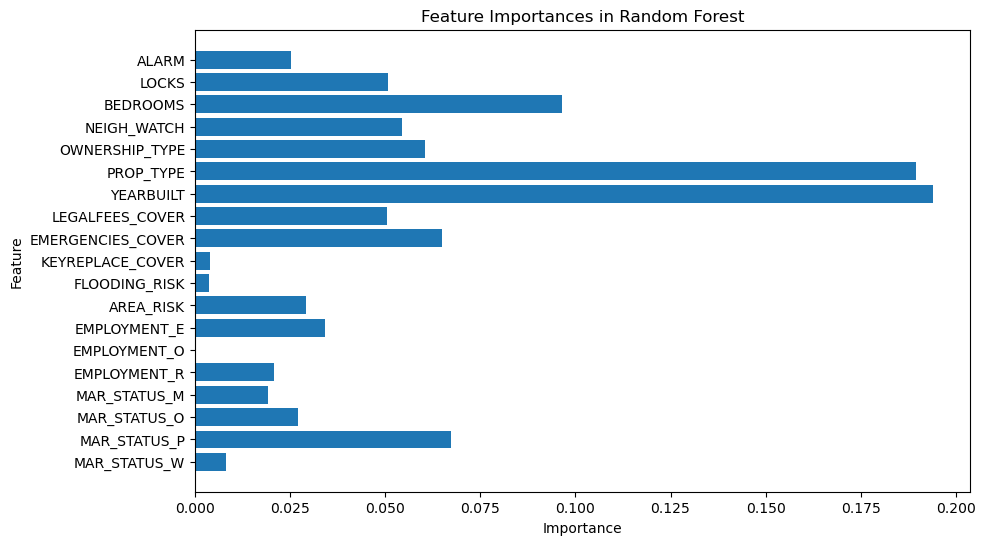

Fitting 5 folds for each of 2400 candidates, totalling 12000 fits


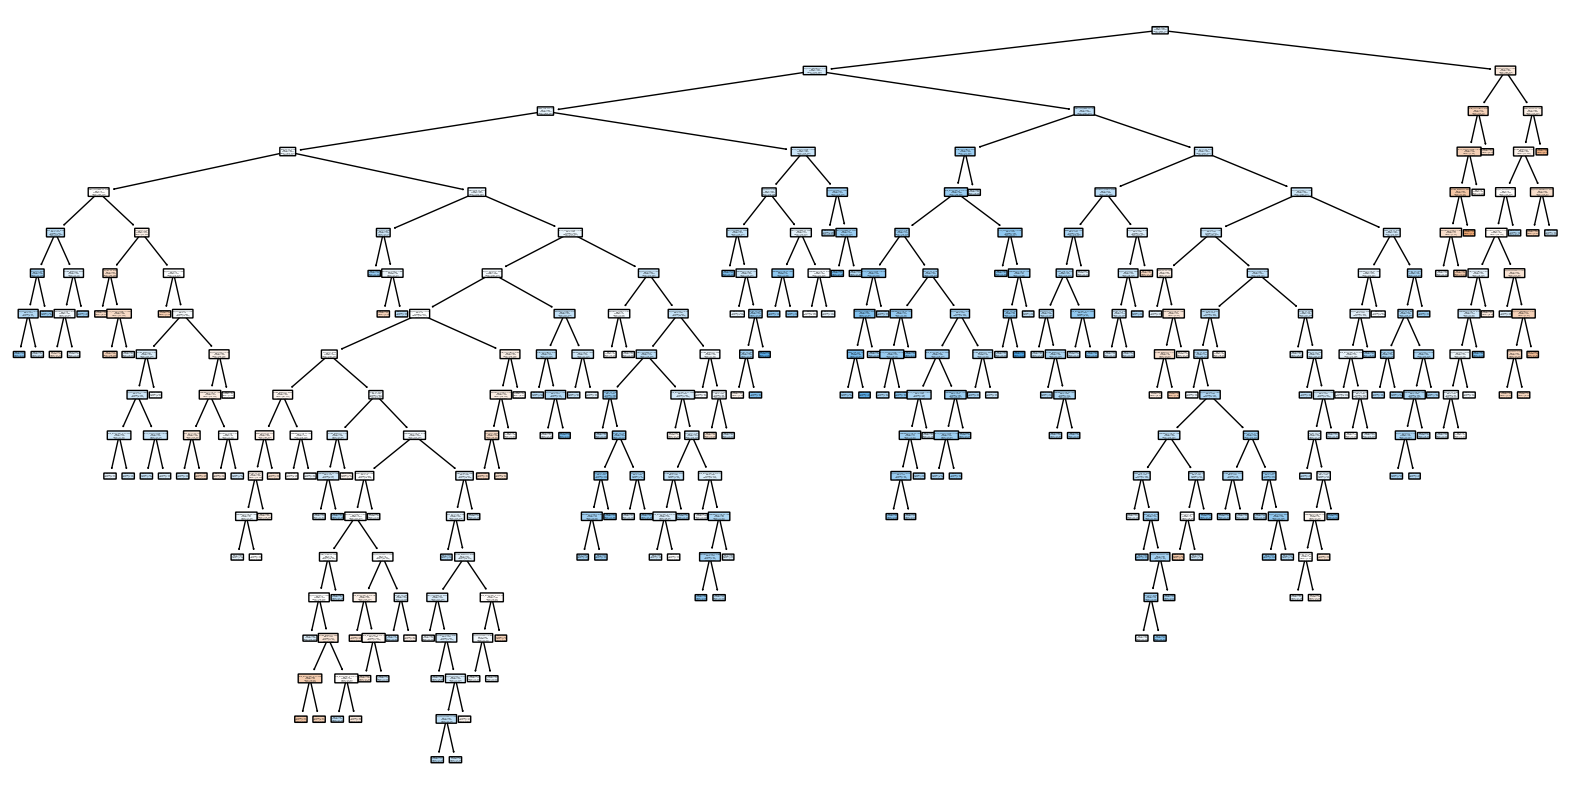

DecisionTree (GridSearchCV)  - Best Parameters: None
DecisionTree (GridSearchCV)  - Best Score: None
TEST High risk policies (correct/incorrect)= 3265/1057
TEST Low risk policies (correct/incorrect)= 1111/2429
VALIDATION High risk policies (correct/incorrect)= 905/274
VALIDATION Low risk policies (correct/incorrect)= 1756/3557



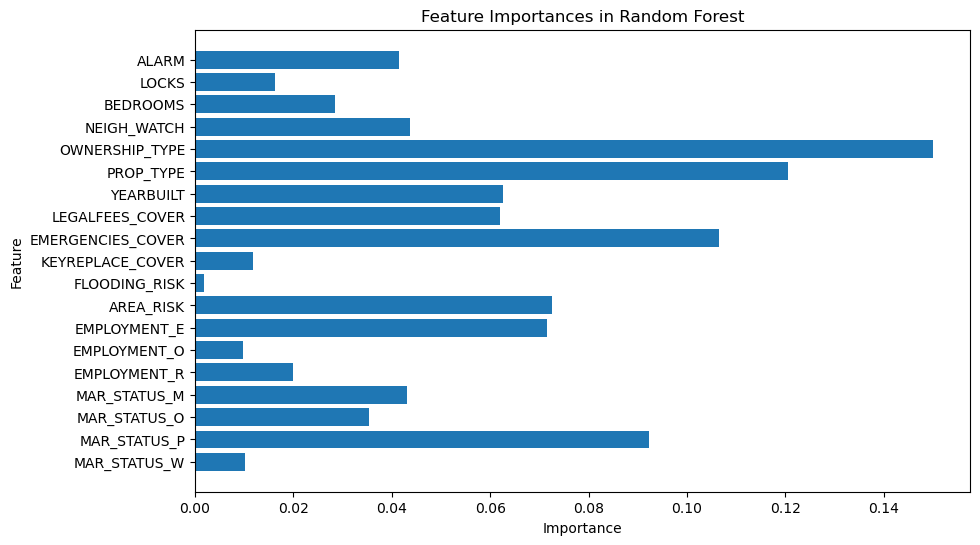

In [6]:
from sklearn.metrics import make_scorer, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

def run_decision_trees_manual():
    decision_tree = DecisionTreeClassifier( class_weight='balanced', 
                                           criterion='gini',
                                           max_depth=10,
                                           max_features='sqrt',
                                           min_samples_leaf=4,
                                           min_samples_split=100,
                                           splitter='best')
    
    decision_tree.fit(X_train, y_train)

    y_pred = decision_tree.predict(X_test)
    
    y_predval = decision_tree.predict(X_validation)

    return ModelResult(y_pred, y_predval, decision_tree, "DecisionTree (Manual)") 


def run_grid_search_decision_trees():

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', DecisionTreeClassifier())
    ])

    param_grid = {
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__splitter': ['best', 'random'],
        'classifier__max_depth': [None, 10, 20, 30, 40, 50],
        'classifier__min_samples_split': [2, 5, 10, 20, 50],
        'classifier__min_samples_leaf': [1, 2, 4, 10, 20],
        'classifier__max_features': [None, 'auto', 'sqrt', 'log2']
    }

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=5,  
        n_jobs=-1,  
        verbose=2
    )

    grid_search.fit(X_train, y_train)

    y_pred = grid_search.predict(X_test)

    y_predval = grid_search.predict(X_validation)

    model = grid_search.best_estimator_.named_steps['classifier']  #grid_search.best_estimator_ 

    plt.figure(figsize=(20,10)) 
    
    tree.plot_tree(model, filled=True, feature_names=columns, class_names=list(X_train.columns), rounded=True)
    
    plt.show()

    return ModelResult(y_pred, y_predval, model, "DecisionTree (GridSearchCV)") 


def run_bayes_optimisation_decision_trees():

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', DecisionTreeClassifier())
    ])

    search_space = {
        'classifier__criterion': Categorical(['gini', 'entropy']),
        'classifier__splitter': Categorical(['best', 'random']),
        'classifier__max_depth': Integer(4, 16),
        'classifier__min_samples_split': Integer(2, 50),
        'classifier__min_samples_leaf': Integer(1, 20),
        'classifier__class_weight': Categorical(['balanced'])
    }

    f1_scorer = make_scorer(f1_score, pos_label=1)

    bayes_search = BayesSearchCV(estimator=pipeline, search_spaces=search_space, n_iter=32, cv=StratifiedKFold(n_splits=5), n_jobs=-1, scoring=f1_scorer, random_state=42)

    bayes_search.fit(X_train, y_train)

    y_pred = bayes_search.predict(X_test)

    y_predval = bayes_search.predict(X_validation)

    model = bayes_search.best_estimator_.named_steps['classifier']  #grid_search.best_estimator_ 

    return ModelResult(y_pred, y_predval, model, "DecisionTree (GridSearchCV)") 


warnings.filterwarnings('ignore')

dt_result_manual = run_decision_trees_manual()

dt_result_manual.print_results(y_test, y_validation)

dt_result_bayes = run_bayes_optimisation_decision_trees()

dt_result_bayes.print_results(y_test, y_validation)

dt_result_bayes.print_features(X_train)

dt_result_gridsearch = run_grid_search_decision_trees()

dt_result_gridsearch.print_results(y_test, y_validation)

dt_result_gridsearch.print_features(X_train)

warnings.filterwarnings('default')





### 8.1.2 Random forest

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
RandomForest (GridSearchCV)  - Best Parameters: None
RandomForest (GridSearchCV)  - Best Score: None
TEST High risk policies (correct/incorrect)= 3307/1015
TEST Low risk policies (correct/incorrect)= 1175/2365
VALIDATION High risk policies (correct/incorrect)= 916/263
VALIDATION Low risk policies (correct/incorrect)= 1765/3548



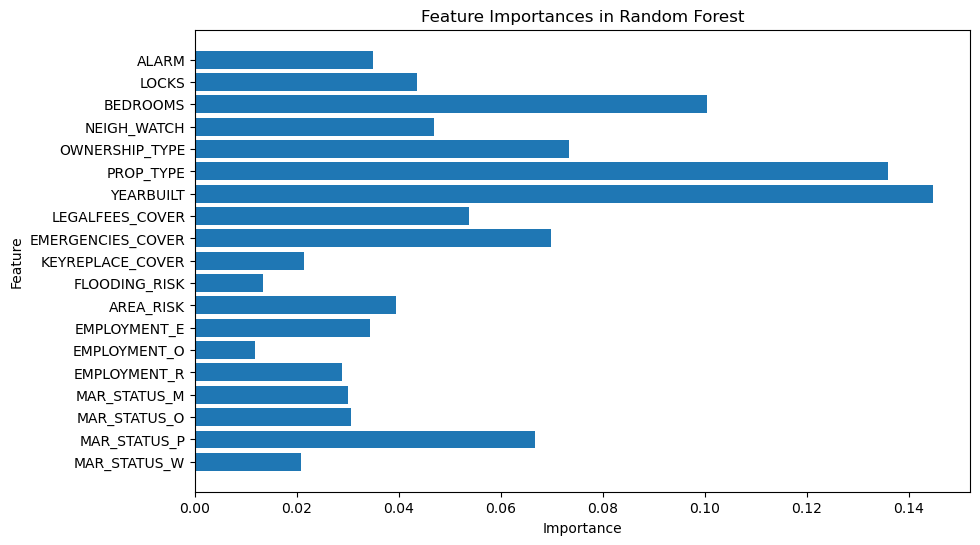

In [7]:
def run_grid_search_random_forest():

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier())
    ])

    param_grid = {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4],
        'classifier__bootstrap': [True, False]
    }

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=StratifiedKFold(n_splits=5),
        n_jobs=-1,
        verbose=2,
        scoring='accuracy'
    )

    grid_search.fit(X_train, y_train)

    y_pred = grid_search.predict(X_test)

    y_predval = grid_search.predict(X_validation)

    model = grid_search.best_estimator_.named_steps['classifier']  #grid_search.best_estimator_ 

    return ModelResult(y_pred, y_predval, model, "RandomForest (GridSearchCV)") 

randomforest_result = run_grid_search_random_forest()

randomforest_result.print_results(y_test, y_validation)

randomforest_result.print_features(X_train)


### 8.1.3 Gradient Boosting

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
GradientBoosting (GridSearchCV)  - Best Parameters: None
GradientBoosting (GridSearchCV)  - Best Score: None
TEST High risk policies (correct/incorrect)= 3181/1141
TEST Low risk policies (correct/incorrect)= 1280/2260
VALIDATION High risk policies (correct/incorrect)= 882/297
VALIDATION Low risk policies (correct/incorrect)= 1962/3351



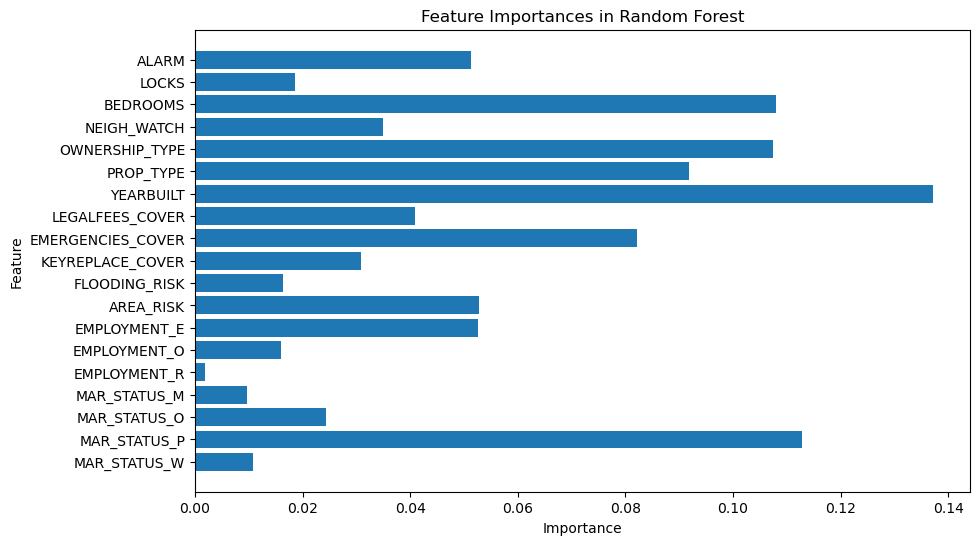

In [8]:
def run_grid_search_gradient_boosting():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', GradientBoostingClassifier())
    ])

    param_grid = {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 4, 5],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4],
        'classifier__subsample': [0.8, 0.9, 1.0]
    }

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=StratifiedKFold(n_splits=5),
        n_jobs=-1,
        verbose=2,
        scoring='accuracy'
    )

    grid_search.fit(X_train, y_train)

    y_pred = grid_search.predict(X_test)

    y_predval = grid_search.predict(X_validation)

    model = grid_search.best_estimator_.named_steps['classifier']  #grid_search.best_estimator_ 

    return ModelResult(y_pred, y_predval, model, "GradientBoosting (GridSearchCV)") 

gradientboosting_result = run_grid_search_gradient_boosting()

gradientboosting_result.print_results(y_test, y_validation)

gradientboosting_result.print_features(X_train)


### Step 8.2

Apply ML technique:  __KNN__

Fitting 5 folds for each of 48 candidates, totalling 240 fits
KNN (GridSearchCV)  - Best Parameters: {'knn__algorithm': 'ball_tree', 'knn__n_neighbors': 11, 'knn__p': 2, 'knn__weights': 'distance'}
KNN (GridSearchCV)  - Best Score: 0.5242669746119859
TEST High risk policies (correct/incorrect)= 2419/1903
TEST Low risk policies (correct/incorrect)= 1764/1776
VALIDATION High risk policies (correct/incorrect)= 662/517
VALIDATION Low risk policies (correct/incorrect)= 2581/2732



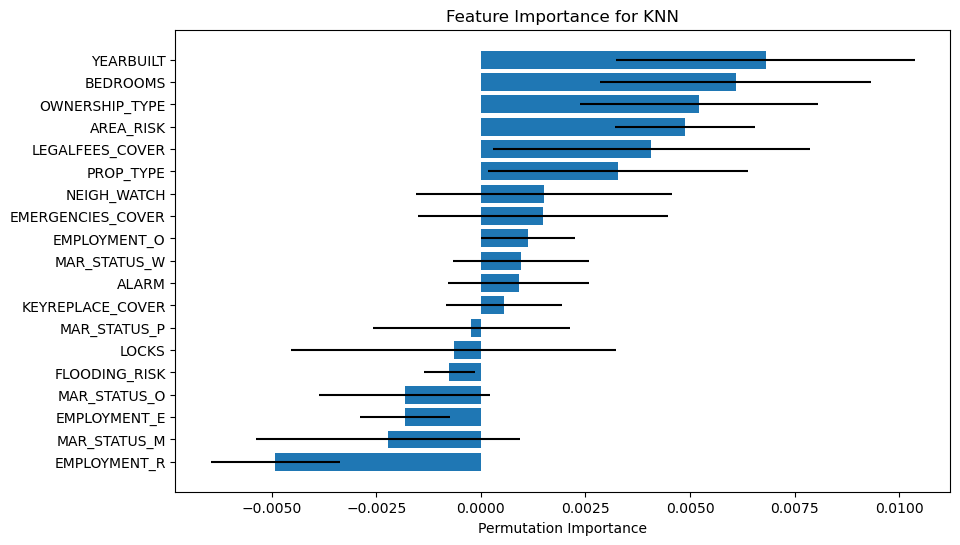

KNN (BayesSearchCV)  - Best Parameters: OrderedDict([('leaf_size', 48), ('n_neighbors', 21), ('p', 2), ('weights', 'distance')])
KNN (BayesSearchCV)  - Best Score: 0.5346454794073703
TEST High risk policies (correct/incorrect)= 2544/1778
TEST Low risk policies (correct/incorrect)= 1673/1867
VALIDATION High risk policies (correct/incorrect)= 707/472
VALIDATION Low risk policies (correct/incorrect)= 2446/2867



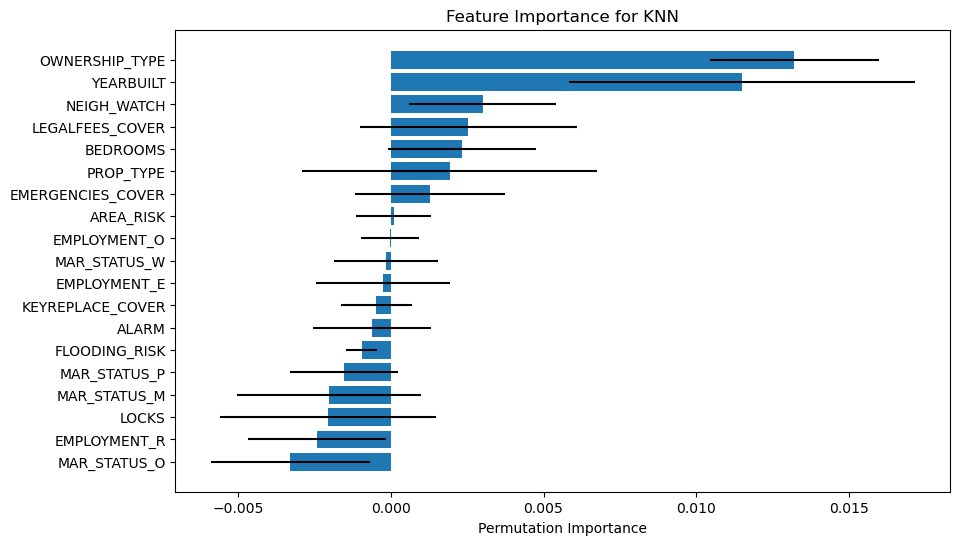

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler





def run_grid_search_knn():

    param_grid = {
        'knn__n_neighbors': [1, 3, 5, 7, 9, 11], 
        'knn__weights': [ 'distance'],  #'uniform',
        'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 
        'knn__p': [1, 2] 
    }

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier())
    ])

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=5,  
        n_jobs=-1,  
        verbose=2
    )

    grid_search.fit(X_train, y_train)

    y_pred = grid_search.predict(X_test)

    y_predval = grid_search.predict(X_validation)

    return ModelResult(y_pred, y_predval, grid_search, "KNN (GridSearchCV)") 


def run_bayes_optimisation_knn():
    search_space = {
        'n_neighbors': (1, 30),
        'leaf_size': (10, 50),
        'p': (1, 2),  # 1 = Manhattan distance and 2 = Euclidean distance
        'weights': [ 'distance']   # there is a bug om sklearn with 'uniform' setting and bayes search, so cannot use this mode here 
    }

    knn = KNeighborsClassifier()

    bayes_search = BayesSearchCV(
        estimator=knn,
        search_spaces=search_space,
        n_iter=10, 
        cv=5,  # Number of cross-validation folds
        random_state=42,
        n_jobs=-1  
    )

    bayes_search.fit(X_train, y_train)

    y_pred = bayes_search.predict(X_test)

    y_predval = bayes_search.predict(X_validation)

    return ModelResult(y_pred, y_predval, bayes_search, "KNN (BayesSearchCV)") 



knn_result_gridsearch = run_grid_search_knn()

knn_result_gridsearch.print_results(y_test, y_validation)

knn_result_gridsearch.print_permutations(X_test, y_test)

knn_result_bayes = run_bayes_optimisation_knn()

knn_result_bayes.print_results(y_test, y_validation)

knn_result_bayes.print_permutations(X_test, y_test)


### Step 8.3

Apply ML technique:  __LogisticRegression Regression__

LogisticRegression (BayesSearchCV)  - Best Parameters: OrderedDict([('logistic__C', 0.006269978992844047), ('logistic__solver', 'lbfgs')])
LogisticRegression (BayesSearchCV)  - Best Score: 0.5692901141980073
TEST High risk policies (correct/incorrect)= 3286/1036
TEST Low risk policies (correct/incorrect)= 1133/2407
VALIDATION High risk policies (correct/incorrect)= 900/279
VALIDATION Low risk policies (correct/incorrect)= 1744/3569



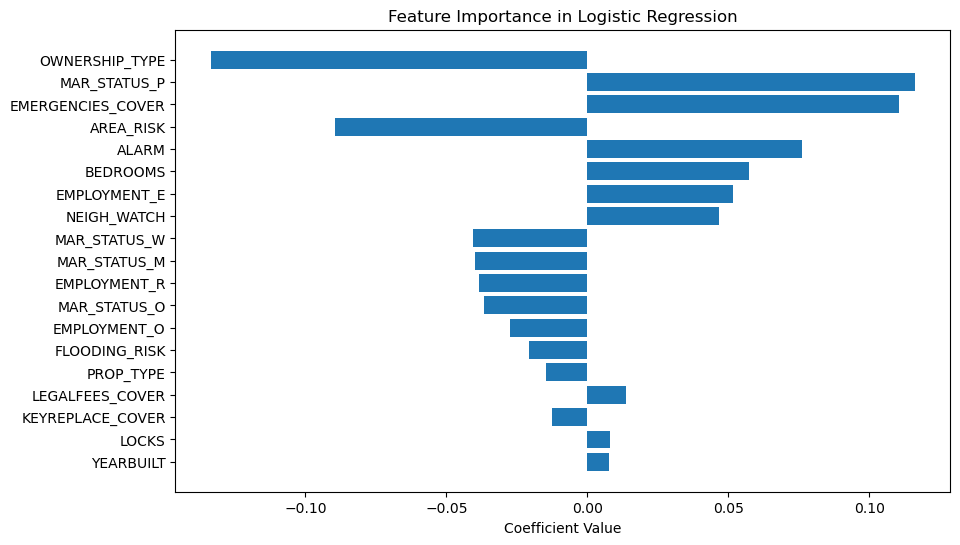

LogisticRegression (GridSearchCV)  - Best Parameters: {'logistic__C': 0.01, 'logistic__solver': 'newton-cg'}
LogisticRegression (GridSearchCV)  - Best Score: 0.5686795436739663
TEST High risk policies (correct/incorrect)= 3279/1043
TEST Low risk policies (correct/incorrect)= 1142/2398
VALIDATION High risk policies (correct/incorrect)= 899/280
VALIDATION Low risk policies (correct/incorrect)= 1753/3560



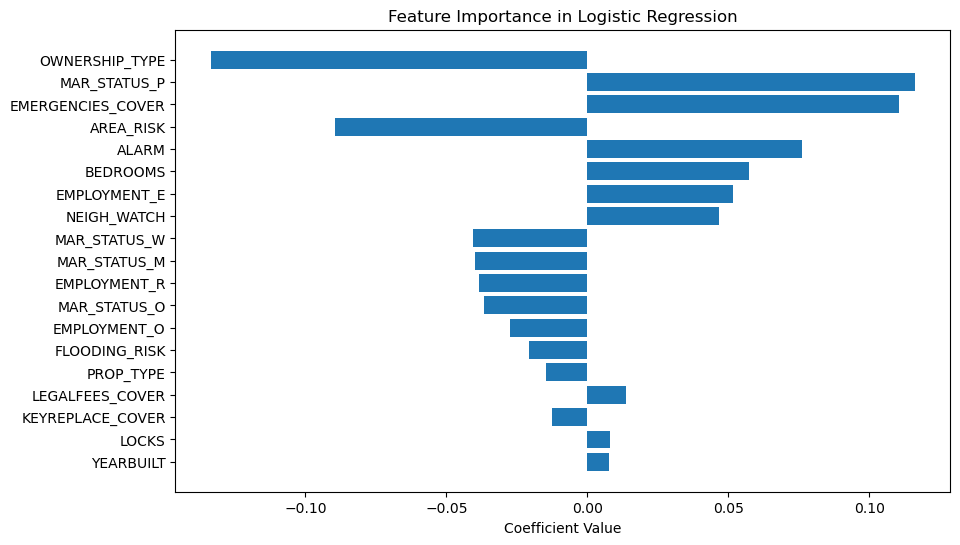

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


def run_grid_search_logistic_regression():
    param_grid = {
        'logistic__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000],  # Regularization strength
        'logistic__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    }

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('logistic', LogisticRegression(max_iter=10000))
    ])

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=5, 
        n_jobs=-1  
    )

    grid_search.fit(X_train, y_train)

    y_pred = grid_search.predict(X_test)

    y_predval = grid_search.predict(X_validation)

    return ModelResult(y_pred, y_predval, grid_search, "LogisticRegression (GridSearchCV)")
    


def run_bayes_optimisation_logistic_regression():
    search_space = {
       'logistic__C': (1e-6, 1e+6, 'log-uniform'),  # Regularization strength
        'logistic__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    }

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('logistic', LogisticRegression())
    ])

    bayes_search = BayesSearchCV(
        estimator=pipeline,
        search_spaces=search_space,
        n_iter=32, 
        cv=5, 
        random_state=42,
        n_jobs=-1  
    )

    bayes_search.fit(X_train, y_train)

    y_pred = bayes_search.predict(X_test)

    y_predval = bayes_search.predict(X_validation)

    

    return ModelResult(y_pred, y_predval, bayes_search, "LogisticRegression (BayesSearchCV)")


log_result_bayes = run_bayes_optimisation_logistic_regression()

log_result_bayes.print_results(y_test, y_validation)

log_result_bayes.print_coefficients(X_train)

#print_confusion_matrix(confusion_matrix(y_validation, log_result_bayes.y_predval))

log_result_gridsearch = run_grid_search_logistic_regression()

log_result_gridsearch.print_results(y_test, y_validation)

log_result_bayes.print_coefficients(X_train)

#print_confusion_matrix(confusion_matrix(y_validation, log_result_gridsearch.y_predval))


### Step 9 Interpret the results.  



See full analysis, criteria selection and final notes below after printing the results

### Step 9.1 - Display all results 

The following list uses the ```ModelResult``` class to print predictions found in test and validation sets. Displaying this information will help make the final decision below

In [11]:
for item in [ dt_result_bayes, 
              dt_result_manual,              
              dt_result_gridsearch, 
              randomforest_result,
              gradientboosting_result,
              knn_result_bayes,
              knn_result_gridsearch,
              log_result_bayes,
              log_result_gridsearch ]: 
    item.print_results(y_test, y_validation)


DecisionTree (GridSearchCV)  - Best Parameters: None
DecisionTree (GridSearchCV)  - Best Score: None
TEST High risk policies (correct/incorrect)= 2262/2060
TEST Low risk policies (correct/incorrect)= 1973/1567
VALIDATION High risk policies (correct/incorrect)= 648/531
VALIDATION Low risk policies (correct/incorrect)= 3001/2312

DecisionTree (Manual)  - Best Parameters: None
DecisionTree (Manual)  - Best Score: None
TEST High risk policies (correct/incorrect)= 1944/2378
TEST Low risk policies (correct/incorrect)= 2322/1218
VALIDATION High risk policies (correct/incorrect)= 563/616
VALIDATION Low risk policies (correct/incorrect)= 3515/1798

DecisionTree (GridSearchCV)  - Best Parameters: None
DecisionTree (GridSearchCV)  - Best Score: None
TEST High risk policies (correct/incorrect)= 3265/1057
TEST Low risk policies (correct/incorrect)= 1111/2429
VALIDATION High risk policies (correct/incorrect)= 905/274
VALIDATION Low risk policies (correct/incorrect)= 1756/3557

RandomForest (GridSear

### Step 9.2 Outcome and final thoughts

The following selection criteria will be used:

- Train and test datasets need a balanced risk/no-risk data to avoid biased results
- Validation dataset has higher number of low risk policies: This is more like normal working conditions and the objective is to identify the high risk policies which is the minority
- Finding high risk policies is more important than low risk policies, so our focus is on true positives and reduce as much as possible the false negatives.

Drumbs playing...

- Best model is: **RandomForest**
- Hyperparameters used: _{'classifier_bootstrap': True, 'classifier_max_depth': 10, 'classifier_min_samples_leaf': 4, 'classifier_min_samples_split': 5, 'classifier_n_estimators': 100}_
- Best score: 78% accuracy (see the selection criteria below)

Based on the above criteria and results obtained it correctly predicted 919 out of 1179 high risk policies, which represents 78% accuracy. The big challenge of this Capstone project is that high risk policies represent a small minority, therefore there is a trade-off between accuracy on low or high risk policies, but sadly cannot achieve high accuracy for both. The following statments describe the journey of tuning of the models:

- The game changer was balancing the ratio of low/high risk policies in the training set, used 80/20, 70/30, 50/50, 30/70, etc. The more balanced on the low risk the higher the accuracy for low risk and the opposite applies too. **Based on business requirements the winner was 45 low/55 high ratio**

- During training on any chosen ratio, all models presented similar results, I would say +/- 3% accuracy between them (not very significant), it was consistent across all different models and same percentage on every different train/test/validation dataset used. The final selection was on the **best accuracy shown for the true positives** and not the overall score

- The validation set was introduced to simulate normal conditions and this set was used to make the final decision
- Tunning hyperparameters presented an accuracy of +/- 3% between different options (not very significant) For instance there was not much difference between bayes optimisation and grid seach, and manual tunning was performed after bayes resutls for further fine tunning, however not much differece was found either.
- If transparency is more important for business than accuracy, we can also choose **Decision Trees using GridSearchCV**, the accuracy is very close and we can print the tree for experts to analyse individual results instead of trusting blindly in the results of a random forest model

### Final remarks:

This was a great experience, I changed the dataset in many ways to balance, scale, remove noise, remove features (using PCA and important_features info) etc. In addition I applied as many optimisations as possible on each model and even introduced extra models for added validation. My conclusion is the dataset is not great, after anaylising some grouped data I discovered some information was generated by an algorithm, e.g. there were more policies for 80+ years than people on their 20 and 30s which makes sense for health insurance but not for property insurance, also there were more flats insured with 5-8 bedrooms than 1-2 bedrooms, considering the rising costs of housing specially for large properties it seems a bit unrealistic. I have the strong feeling that this model been trained with more realistic data will provide much higher accuracy, perhaps up to 90%